# Модель машиннго обучения - CatBootRegressor()!!!

In [1]:
import pandas as pd # работа с данными / python data analysis library
import numpy as np # работа с числовыми данными / python numerical computing library
import seaborn as sns # визуализация данных / python data visualization library
import matplotlib.pyplot as plt # визуализация данных / python data visualization library

from sklearn.metrics import mean_absolute_error # метрика средняя абсолютная ошибка / mean absolute error
from sklearn.metrics import mean_squared_error # метрика средняя квадратичная ошибка / mean squared error
from sklearn.metrics import mean_absolute_percentage_error # метрика средняя абсолютная процентная ошибка / mean absolute percentage error

from sklearn.feature_selection import SelectKBest, f_regression # алгоритм для выбора признаков с наивысшими оценками в модели машинного обучения на основе статистических тестов / f-regression одномерный тест линейной регрессии  

from sklearn.preprocessing import MinMaxScaler # алгоритм стандартизации данных / MinMaxScaler

from sklearn.model_selection import train_test_split # разделение выборки на обучающую и тестовую / train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from sklearn.model_selection import RandomizedSearchCV # подбор гиперпараметров
from sklearn.model_selection import GridSearchCV # подбор гиперпараметров

import catboost as cb # алгоритм экстремального градиентного бустинга
from catboost import CatBoostRegressor # алгоритм экстремального градиентного бустинга для регрессии из библиотеки catboost 

from joblib import dump, load # сохранение и загрузка модели / 

from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

import optuna # библиотека для автоматического поиска гиперпараметров моделей машинного обучения hyperparameter optimization framework to automate hyperparameter search in machine learning models 
optuna.logging.set_verbosity(optuna.logging.WARNING) # отключаем вывод промежуточных итогов вычислений

# отключаем предупреждения
import warnings 
warnings.filterwarnings("ignore")


Тренировочная выборка:
     RMSE: 0.35
     MAE: 0.24
     MAPE: 1.89%
Валидационная выборка:
     RMSE: 0.37
     MAE: 0.25
     MAPE: 1.97%
Тестовая выборка:
     RMSE: 0.37
     MAE: 0.25
     MAPE: 1.98%


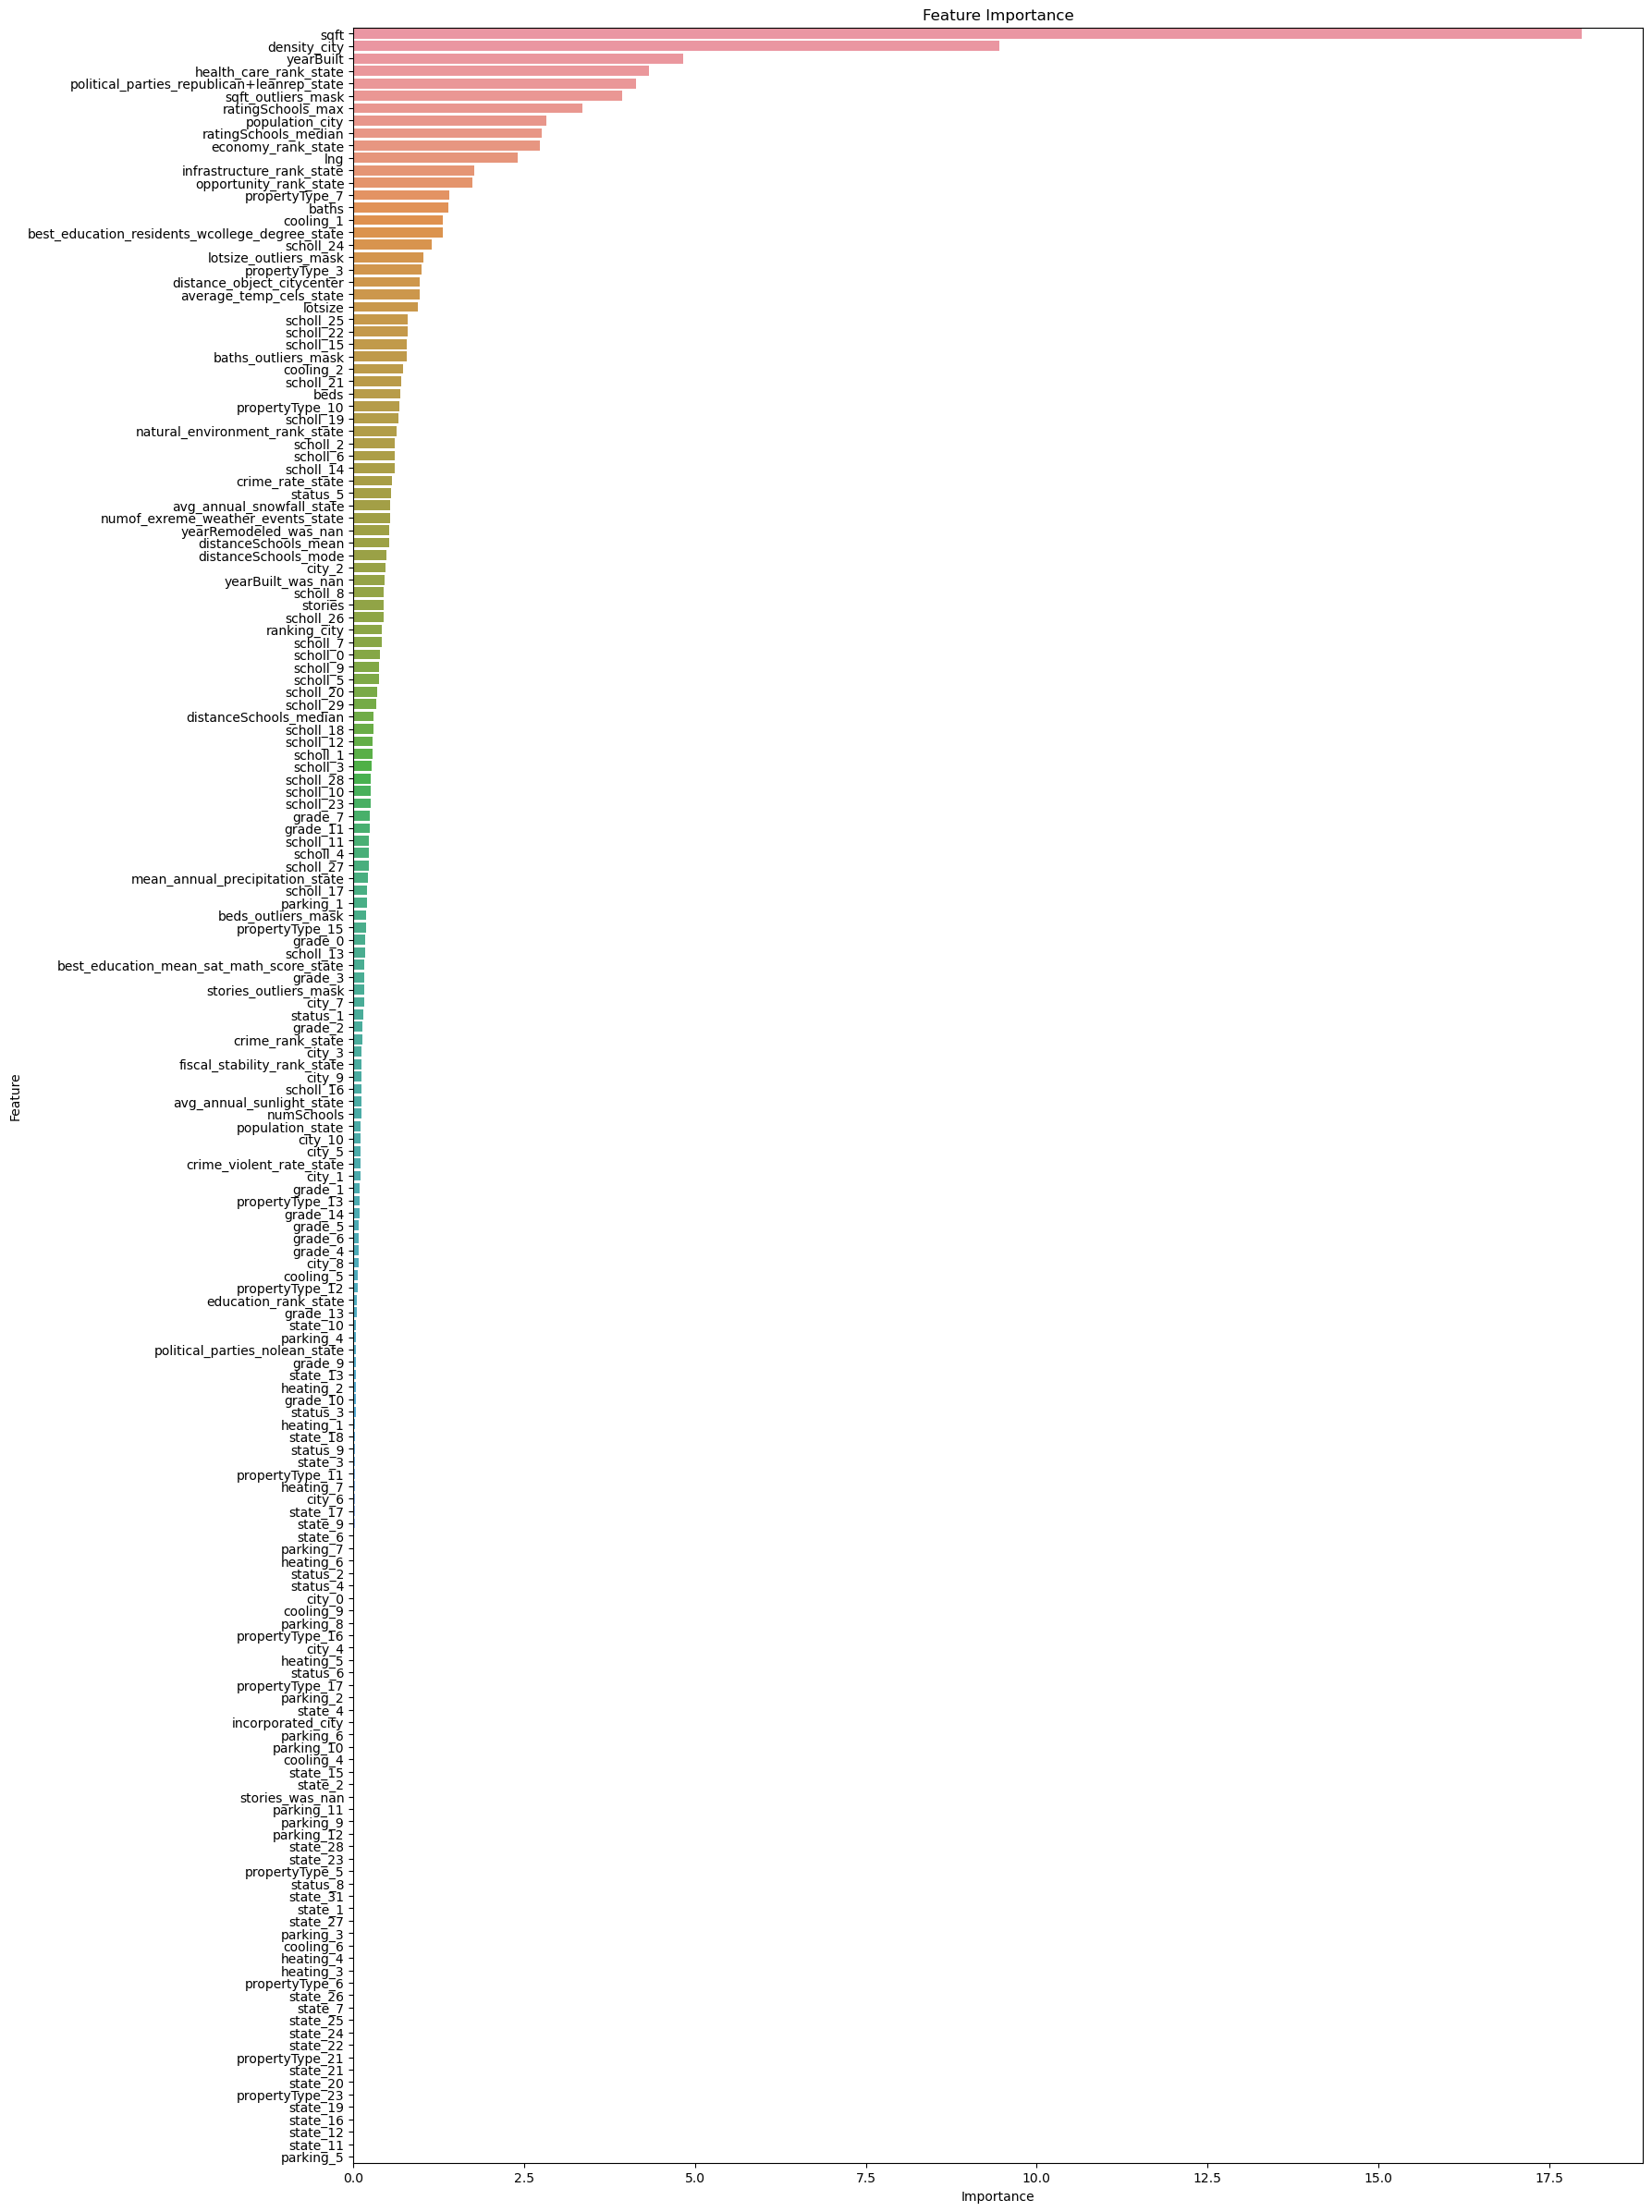

In [2]:
#%%time # подсчет времени выполнения
# фиксируем RANDOM_SEED, для воспроизводимости кода.
RANDOM_SEED = 369

# загружаем данные
data_cbr = pd.read_csv("data/data_final.csv", sep=",")

# создаем матрицу наблюдений и вектор правильных ответов
X = data_cbr.drop(columns="target", axis=1)
y = data_cbr["target"]

# производим разделение выборки на тренировочную и тестовую
X_train, X_validtest, y_train, y_validtest = train_test_split(X, y, train_size=0.7, random_state=RANDOM_SEED)
X_valid, X_test, y_valid, y_test = train_test_split(X_validtest, y_validtest, test_size=0.5, random_state=RANDOM_SEED)

# # производим отбор наиболее важных признаков
# selector = SelectKBest(score_func=f_regression, k=50)
# selector.fit(X_train, y_train)
# best_features = selector.get_feature_names_out()
# X_train = X_train[best_features]
# X_valid = X_valid[best_features]
# X_test = X_test[best_features]

# формируем лист признаков для графика
feature_names = X_train.columns.tolist()

# производим нормализацию обучающей и тестовой выборки с помощью MinMaxScaller
min_max_scaler = MinMaxScaler()
min_max_scaler.fit(X_train)
X_train = min_max_scaler.transform(X_train)
X_valid = min_max_scaler.transform(X_valid)
X_test = min_max_scaler.transform(X_test)

model_cbr = CatBoostRegressor(loss_function="RMSE",
                              verbose=0)
model_cbr.fit(X_train, y_train)

# делаем предсказание на тестовом наборе данных
y_train_predict_cbr = model_cbr.predict(X_train)
y_valid_predict_cbr = model_cbr.predict(X_valid)
y_test_predict_cbr = model_cbr.predict(X_test)

# выводим метрики оценки качества
print()
print("Тренировочная выборка:")
print("     RMSE: {:.2f}".format(np.sqrt(mean_squared_error(y_train, y_train_predict_cbr))))
print("     MAE: {:.2f}".format(mean_absolute_error(y_train, y_train_predict_cbr)))
print("     MAPE: {:.2f}%".format(mean_absolute_percentage_error(y_train, y_train_predict_cbr)*100))
print("Валидационная выборка:")
print("     RMSE: {:.2f}".format(np.sqrt(mean_squared_error(y_valid, y_valid_predict_cbr))))
print("     MAE: {:.2f}".format(mean_absolute_error(y_valid, y_valid_predict_cbr)))
print("     MAPE: {:.2f}%".format(mean_absolute_percentage_error(y_valid, y_valid_predict_cbr)*100))
print("Тестовая выборка:")
print("     RMSE: {:.2f}".format(np.sqrt(mean_squared_error(y_test, y_test_predict_cbr))))
print("     MAE: {:.2f}".format(mean_absolute_error(y_test, y_test_predict_cbr)))
print("     MAPE: {:.2f}%".format(mean_absolute_percentage_error(y_test, y_test_predict_cbr)*100))

# График важности признаков с помощью библиотеки seaborn
feature_importance = model_cbr.feature_importances_
#feature_names = X.columns
feature_importance_df = pd.DataFrame({"Feature": feature_names, "Importance": feature_importance})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)
plt.figure(figsize=(18, 30))
sns.barplot(x="Importance", y="Feature", data=feature_importance_df)
plt.title("Feature Importance")
plt.show()

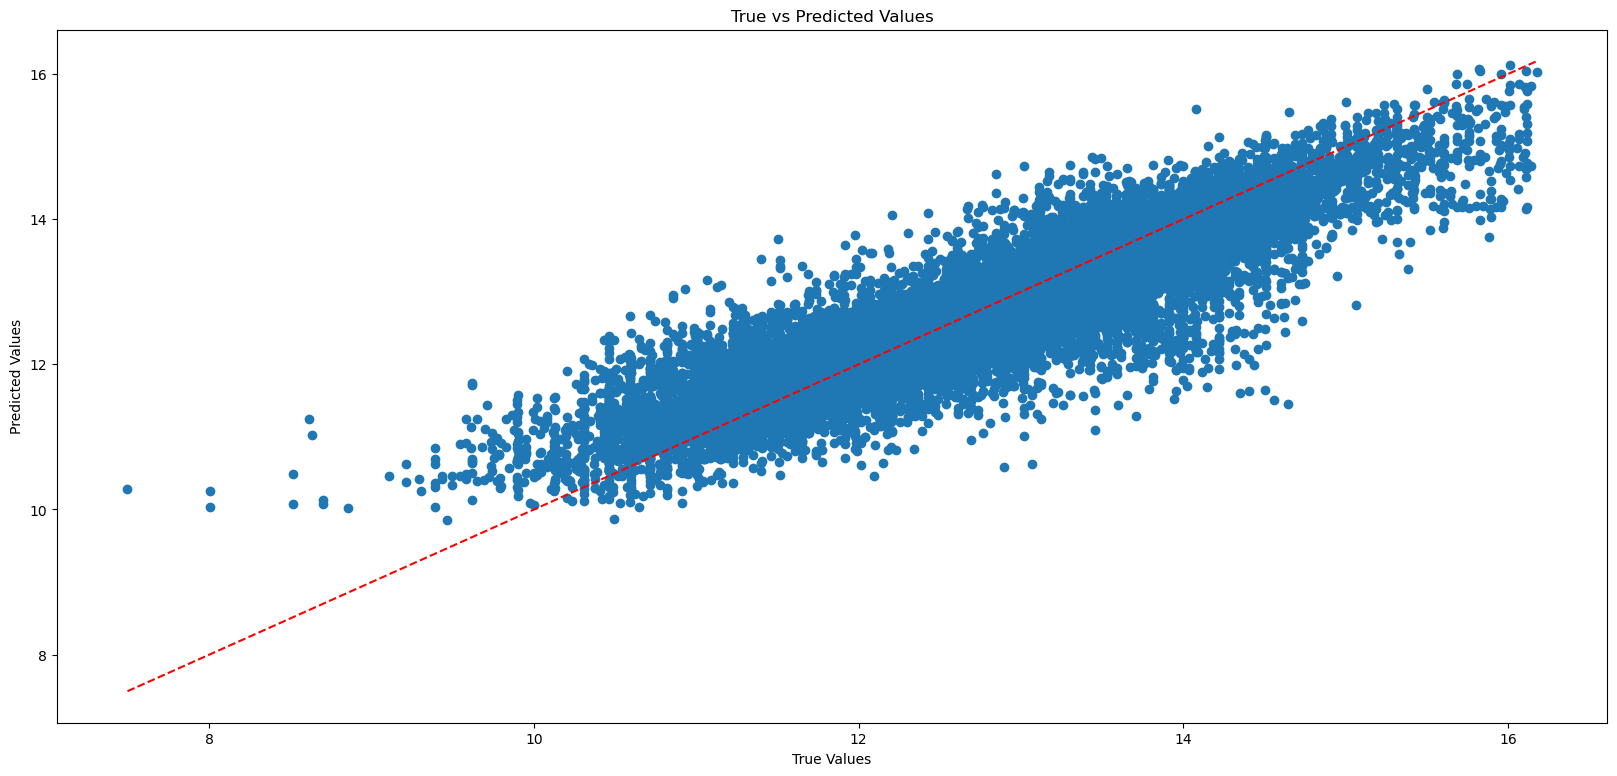

In [3]:
# график предсказанных значений против истинных значений на тестовой выборке
y_pred = y_test_predict_cbr
plt.figure(figsize=(20, 9))
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle="--", color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted Values")
plt.show()

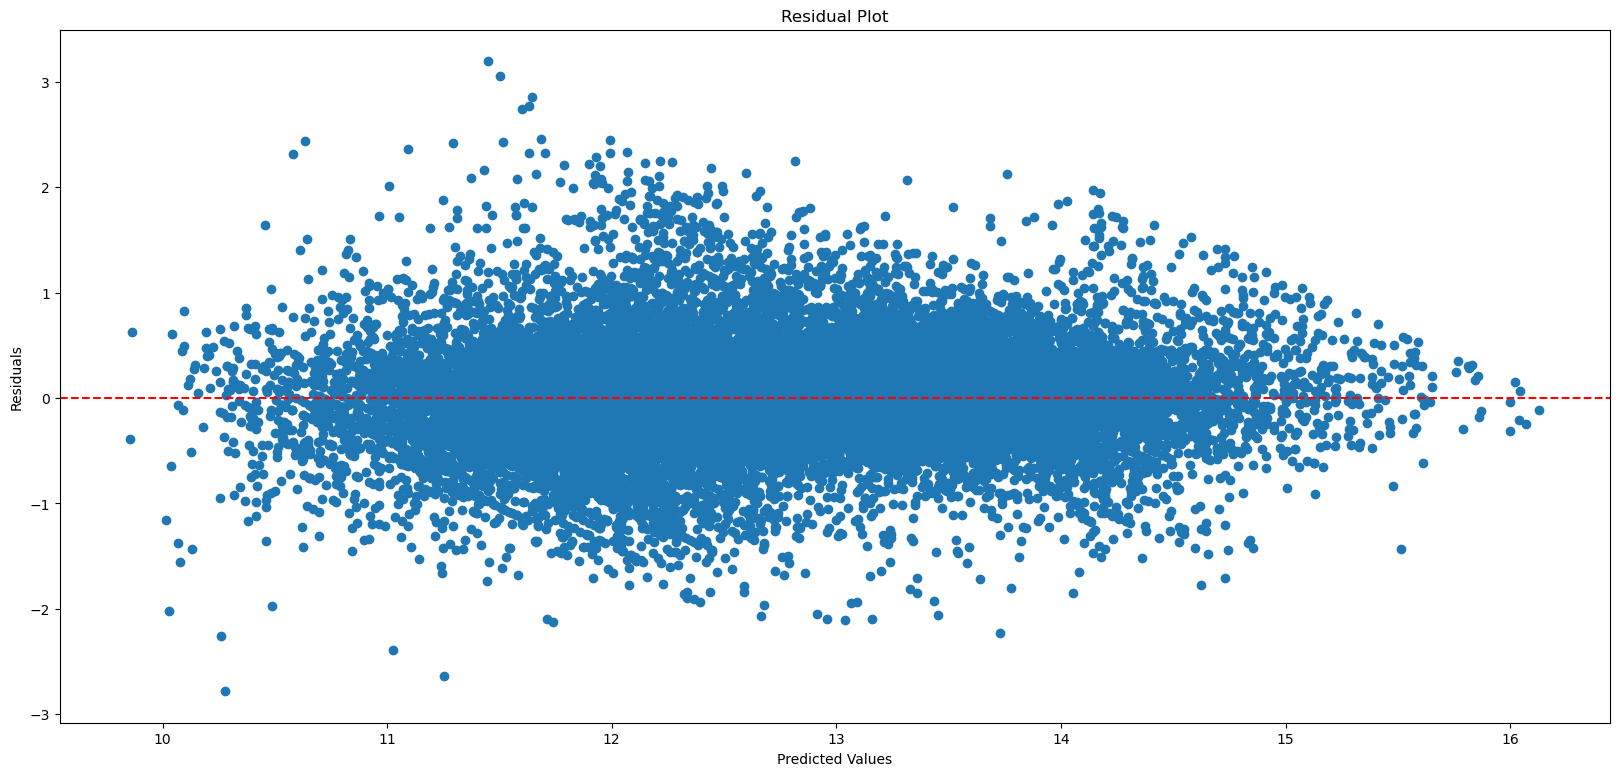

In [4]:
# график остатков на тестовой выборке
residuals = y_test - y_pred
plt.figure(figsize=(20, 9))
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

In [5]:
# cохраняем модель в файл
dump(model_cbr, "model/model_CatBoost.joblib")

['model/model_CatBoost.joblib']

#### Optimization library - **OPTUNA** - Подбор гиперпараметров

In [6]:
# описываем функцию для подбора гиперпараметров
def optuna_objective(trial):
    # задаем диапазон значений гиперпараметров
    param = {
        "verbose": 0,
        "eval_metric": "RMSE",
        "iterations": trial.suggest_int("iterations", 10, 500),
        "depth": trial.suggest_int("depth", 3, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-8, 10.0, log=False),
        "learning_rate": trial.suggest_float("learning_rate", 1e-8, 1.0, log=False),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.1, 1.0),
        "subsample": trial.suggest_float("subsample", 0.1, 1.0),
        "random_strength": trial.suggest_float("random_strength", 1e-8, 1.0, log=False),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 10.0),
        "border_count": trial.suggest_int("border_count", 1, 255)
    }

    # обучаем модель с ранней остановкой
    optuna_cbr = CatBoostRegressor(**param)
    optuna_cbr.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=50, verbose=False)

    # делаем предсказания на валидационных данных
    y_pred = optuna_cbr.predict(X_valid)
    mae = mean_absolute_error(y_valid, y_pred)

    # сообщаем оптимизатору текущий результат
    trial.report(mae, optuna_cbr.best_iteration_)

    # проверяем, следует ли обрезать пробу
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()

    return mae

# создаем и оптимизируем исследование с MedianPruner
study = optuna.create_study(direction="minimize", pruner=optuna.pruners.MedianPruner())
study.optimize(optuna_objective, n_trials=100, show_progress_bar=True)

# выводим лучшие параметры
best_params = study.best_trial.params
print(f"Лучшие параметры: {best_params}")

  0%|          | 0/100 [00:00<?, ?it/s]

Лучшие параметры: {'iterations': 468, 'depth': 10, 'l2_leaf_reg': 0.9417247281985138, 'learning_rate': 0.2741580101436693, 'colsample_bylevel': 0.8431804687334538, 'subsample': 0.5402323279831804, 'random_strength': 0.4889033105512306, 'bagging_temperature': 5.065941602916879, 'border_count': 74}


In [7]:
# обучаем модель CatBoost с подобранными параметрами
model_cbr_optuna = CatBoostRegressor(**best_params, verbose=0)
model_cbr_optuna.fit(X_train, y_train)

# делаем предсказание на тестовом наборе данных
y_train_predict_cbr_opt = model_cbr_optuna.predict(X_train)
y_valid_predict_cbr_opt = model_cbr_optuna.predict(X_valid)
y_test_predict_cbr_opt = model_cbr_optuna.predict(X_test)

# выводим метрики оценки качества
print()
print("Тренировочная выборка:")
print("     RMSE: {:.2f}".format(np.sqrt(mean_squared_error(y_train, y_train_predict_cbr_opt))))
print("     MAE: {:.2f}".format(mean_absolute_error(y_train, y_train_predict_cbr_opt)))
print("     MAPE: {:.2f}%".format(mean_absolute_percentage_error(y_train, y_train_predict_cbr_opt)*100))
print("Валидационная выборка:")
print("     RMSE: {:.2f}".format(np.sqrt(mean_squared_error(y_valid, y_valid_predict_cbr_opt))))
print("     MAE: {:.2f}".format(mean_absolute_error(y_valid, y_valid_predict_cbr_opt)))
print("     MAPE: {:.2f}%".format(mean_absolute_percentage_error(y_valid, y_valid_predict_cbr_opt)*100))
print("Тестовая выборка:")
print("     RMSE: {:.2f}".format(np.sqrt(mean_squared_error(y_test, y_test_predict_cbr_opt))))
print("     MAE: {:.2f}".format(mean_absolute_error(y_test, y_test_predict_cbr_opt)))
print("     MAPE: {:.2f}%".format(mean_absolute_percentage_error(y_test, y_test_predict_cbr_opt)*100))


Тренировочная выборка:
     RMSE: 0.24
     MAE: 0.16
     MAPE: 1.30%
Валидационная выборка:
     RMSE: 0.34
     MAE: 0.22
     MAPE: 1.73%
Тестовая выборка:
     RMSE: 0.34
     MAE: 0.22
     MAPE: 1.75%


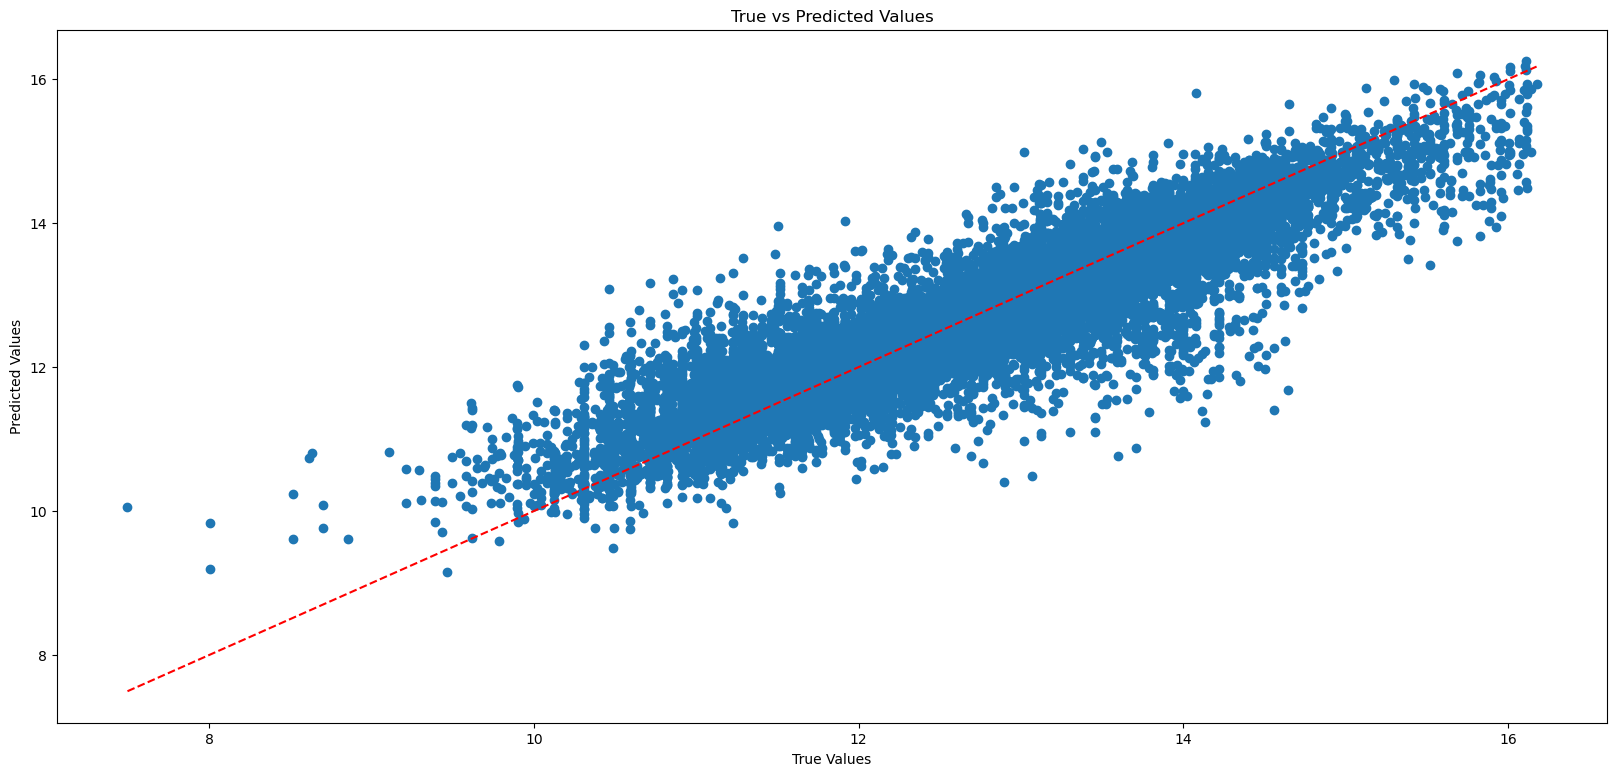

In [8]:
# график предсказанных значений против истинных значений на тестовой выборке
y_pred = y_test_predict_cbr_opt
plt.figure(figsize=(20, 9))
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle="--", color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted Values")
plt.show()

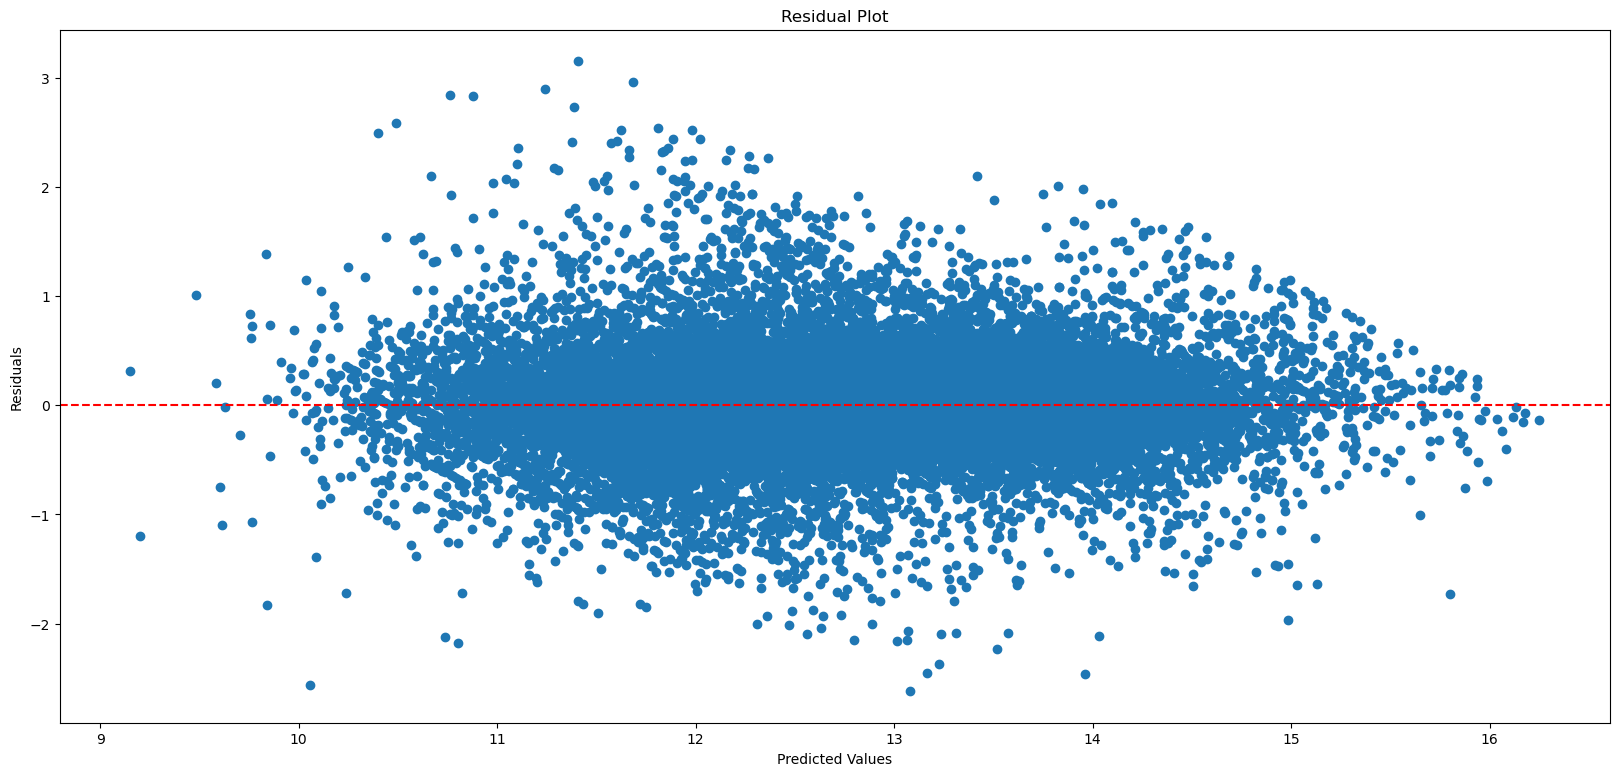

In [9]:
# график остатков на тестовой выборке
residuals = y_test - y_pred
plt.figure(figsize=(20, 9))
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

In [10]:
# формируем и выводим график истории оптимизации
optuna.visualization.plot_optimization_history(study, target_name="mae")

In [11]:
# формируем и выводим график важности гиперпараметров
optuna.visualization.plot_param_importances(study, target_name="mae")

In [12]:
# визуализация контуров гиперпараметров
optuna.visualization.plot_contour(study, params=["depth", "learning_rate"], target_name="mae")

In [13]:
# визуализация среза
optuna.visualization.plot_slice(study, target_name="mae")

In [14]:
# визуализация промежуточных значений (полезна, если вы используете промежуточные значения во время оптимизации)
optuna.visualization.plot_intermediate_values(study)

In [15]:
# визуализация прогресса оптимизации для параллельной координатной плоскости
optuna.visualization.plot_parallel_coordinate(study, target_name="mae")

In [16]:
# визуализация соотношения гиперпараметров к целевой метрике
optuna.visualization.plot_edf(study, target_name="mae")

In [17]:
# cохраняем модель в файл
dump(model_cbr_optuna, "model/model_CatBoostOptuna.joblib")

['model/model_CatBoostOptuna.joblib']

#### Optimization library **Hyperopt** - подбор гиперпараметров модели

In [18]:
# определяем пространство поиска гиперпараметров
space = {
    "iterations": hp.quniform("iterations", 10, 500, 1),
    "depth": hp.quniform("depth", 3, 10, 1),
    "l2_leaf_reg": hp.uniform("l2_leaf_reg", 1e-8, 10.0),
    "learning_rate": hp.uniform("learning_rate", 1e-8, 1.0),
    "colsample_bylevel": hp.uniform("colsample_bylevel", 0.1, 1.0),
    "subsample": hp.uniform("subsample", 0.1, 1.0),
    "random_strength": hp.uniform("random_strength", 1e-8, 1.0),
    "bagging_temperature": hp.uniform("bagging_temperature", 0.0, 10.0),
    "border_count": hp.quniform("border_count", 1, 255, 1)
}

# определяем функцию для подбора гиперпараметров
def hyperopt_objective(params):
    # Приводим типы параметров к нужному виду
    params["iterations"] = int(params["iterations"])
    params["depth"] = int(params["depth"])
    params["border_count"] = int(params["border_count"])
    
    # создаем и обучаем модель
    model = CatBoostRegressor(
        eval_metric="RMSE",
        verbose=0,
        **params
    )
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=50, verbose=False)
    
    # делаем предсказания и вычисляем метрику
    y_pred = model.predict(X_valid)
    mae = mean_absolute_error(y_valid, y_pred)
    
    return {'loss': mae, 'status': STATUS_OK}

# запускаем оптимизацию
trials = Trials()
best = fmin(
    fn=hyperopt_objective,
    space=space,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials,
    rstate=np.random.default_rng(123)  # для воспроизводимости
)

print(f"Лучшие параметры: {best}")

100%|██████████| 50/50 [07:55<00:00,  9.52s/trial, best loss: 0.22304766716680324]
Лучшие параметры: {'bagging_temperature': 9.875544759060155, 'border_count': 84.0, 'colsample_bylevel': 0.49710681951682417, 'depth': 10.0, 'iterations': 369.0, 'l2_leaf_reg': 2.0606007714811803, 'learning_rate': 0.41183666431664023, 'random_strength': 0.5602317186619726, 'subsample': 0.8196067923808994}


In [19]:
# продолжим подбор параметров, увеличиваем max_evals(должен быть строго больше, чем на предыдуших итерациях) и используем старый trials
best=fmin(hyperopt_objective, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=100, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(RANDOM_SEED) # фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

100%|██████████| 100/100 [11:15<00:00, 13.51s/trial, best loss: 0.2209446630299443]
Наилучшие значения гиперпараметров {'bagging_temperature': 9.748666152551243, 'border_count': 83.0, 'colsample_bylevel': 0.5552388302778799, 'depth': 10.0, 'iterations': 469.0, 'l2_leaf_reg': 6.7766764474329015, 'learning_rate': 0.273390193650641, 'random_strength': 0.09318760172437333, 'subsample': 0.9983015529567587}


In [20]:
# обучаем модель CatBoost с подобранными параметрами
model_cbr_hyperopt = CatBoostRegressor(**best, verbose=0)
model_cbr_hyperopt.fit(X_train, y_train)

# делаем предсказание на тренировочном, валидном и тестовом наборе данных
y_train_predict_cbr_hyp = model_cbr_hyperopt.predict(X_train)
y_valid_predict_cbr_hyp = model_cbr_hyperopt.predict(X_valid)
y_test_predict_cbr_hyp = model_cbr_hyperopt.predict(X_test)

# выводим метрики оценки качества
print()
print("Тренировочная выборка:")
print("     RMSE: {:.2f}".format(np.sqrt(mean_squared_error(y_train, y_train_predict_cbr_hyp))))
print("     MAE: {:.2f}".format(mean_absolute_error(y_train, y_train_predict_cbr_hyp)))
print("     MAPE: {:.2f}%".format(mean_absolute_percentage_error(y_train, y_train_predict_cbr_hyp)*100))
print("Валидационная выборка:")
print("     RMSE: {:.2f}".format(np.sqrt(mean_squared_error(y_valid, y_valid_predict_cbr_hyp))))
print("     MAE: {:.2f}".format(mean_absolute_error(y_valid, y_valid_predict_cbr_hyp)))
print("     MAPE: {:.2f}%".format(mean_absolute_percentage_error(y_valid, y_valid_predict_cbr_hyp)*100))
print("Тестовая выборка:")
print("     RMSE: {:.2f}".format(np.sqrt(mean_squared_error(y_test, y_test_predict_cbr_hyp))))
print("     MAE: {:.2f}".format(mean_absolute_error(y_test, y_test_predict_cbr_hyp)))
print("     MAPE: {:.2f}%".format(mean_absolute_percentage_error(y_test, y_test_predict_cbr_hyp)*100))


Тренировочная выборка:
     RMSE: 0.27
     MAE: 0.18
     MAPE: 1.42%
Валидационная выборка:
     RMSE: 0.34
     MAE: 0.22
     MAPE: 1.75%
Тестовая выборка:
     RMSE: 0.34
     MAE: 0.22
     MAPE: 1.77%


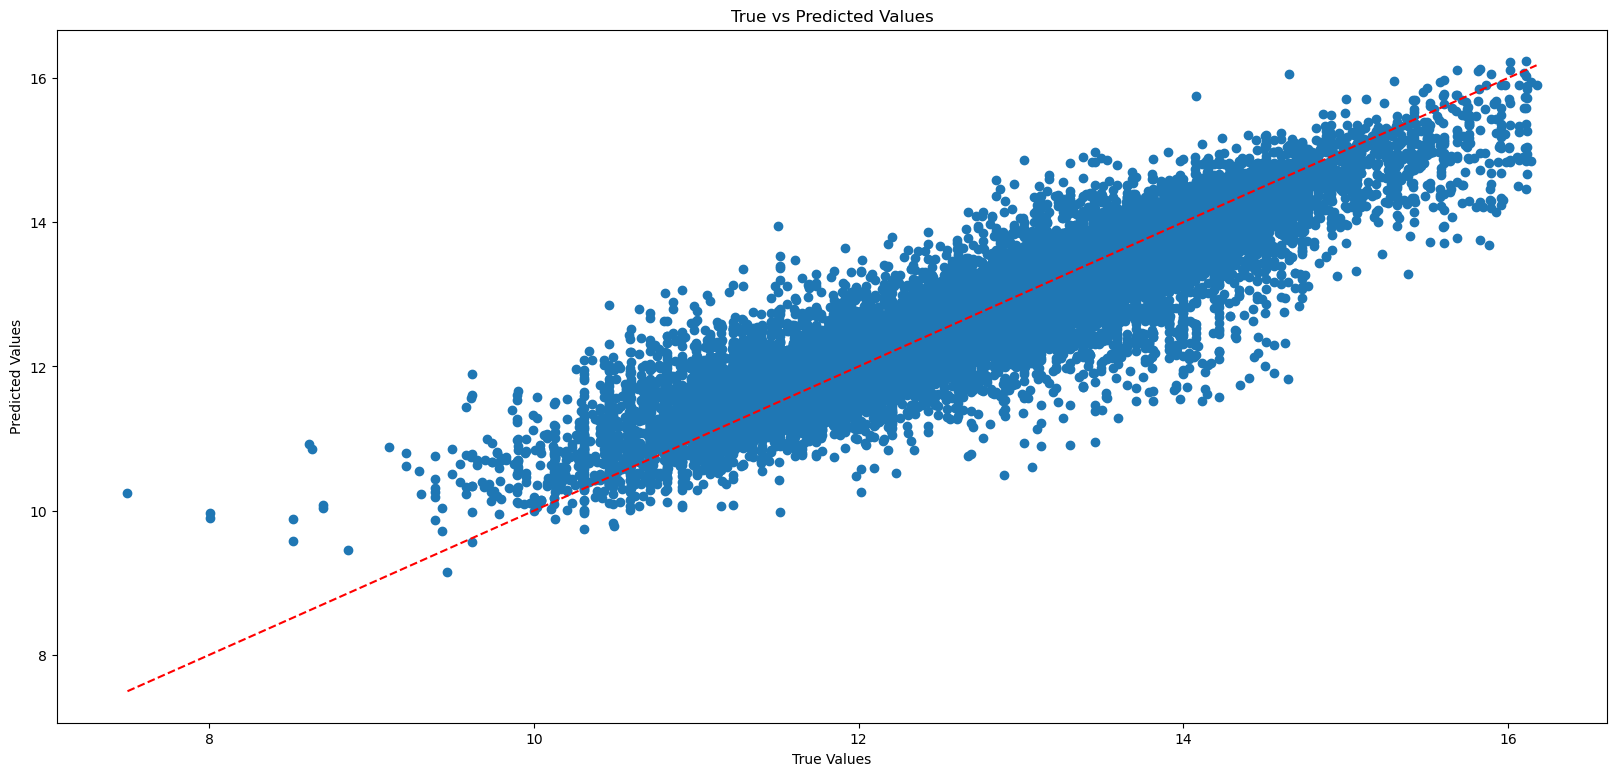

In [21]:
# график предсказанных значений против истинных значений на тестовой выборке
y_pred = y_test_predict_cbr_hyp
plt.figure(figsize=(20, 9))
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle="--", color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted Values")
plt.show()

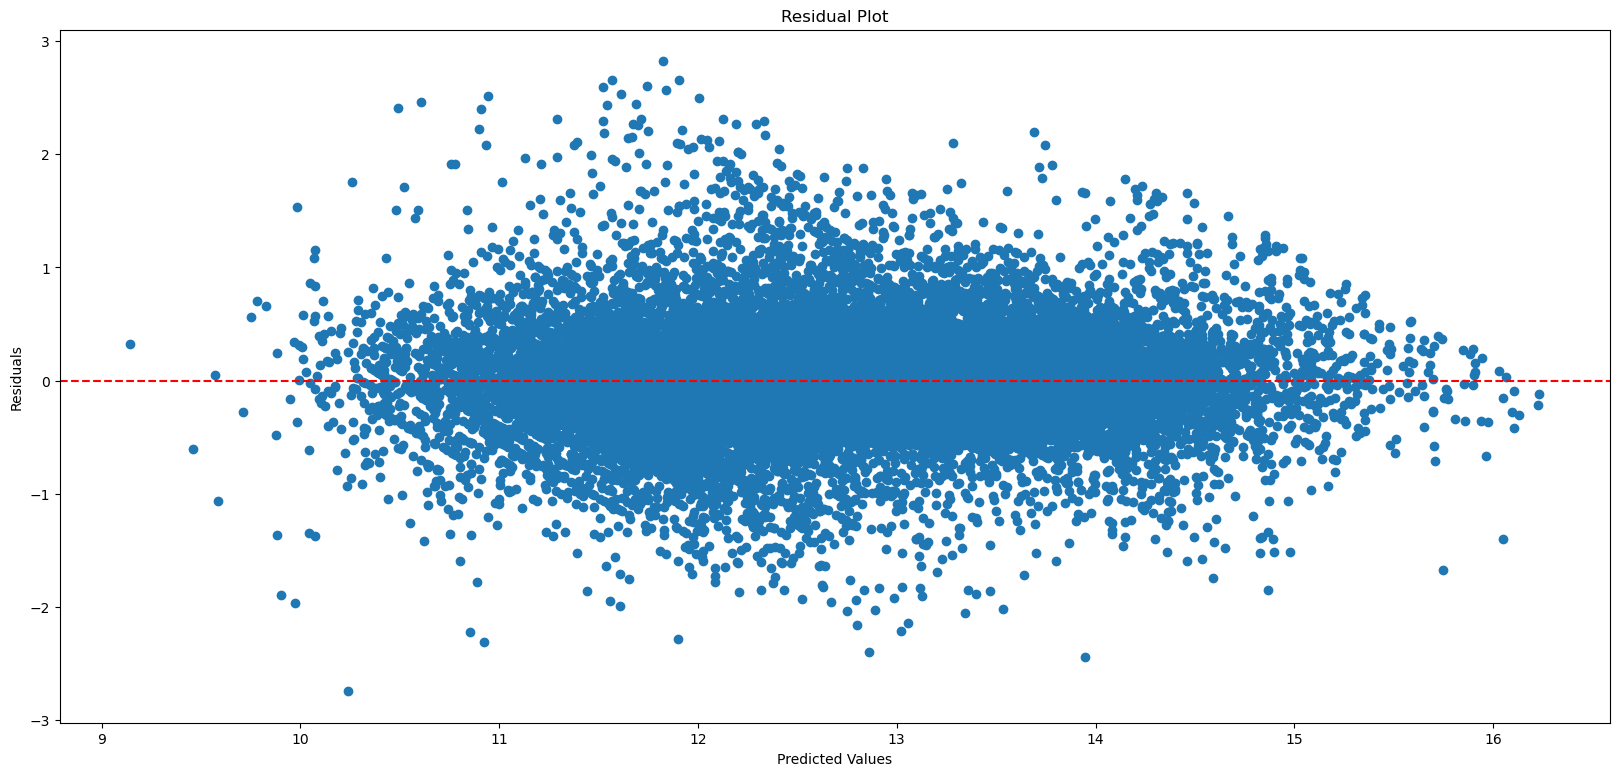

In [22]:
# график остатков на тестовой выборке
residuals = y_test - y_pred
plt.figure(figsize=(20, 9))
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

In [23]:
# cохраняем модель в файл
dump(model_cbr_hyperopt, "model/model_CatBoostHyperopt.joblib")

['model/model_CatBoostHyperopt.joblib']

In [24]:
# в данную переменную буду сохранять результаты моделей [RSME, MAE, MAPE и название алгоритма]
results = []

# описываем функцию для оценки модели, а также для сохранения значений метрик и последующего использования
def results_model(model, X_train, y_train, X_valid, y_valid, X_test, y_test, model_name, results):
  """Функция для вывода результатов score для train, valid и test, а также для сохранения этих значений для последующего использования.
    
  Аргументы:
    model (model): обученная модель, которую необходимо оценить;
    model_name (string): название используемой модели.
  """
  model_result = []
  # предсказания и оценка для тренировочных данных
  y_train = np.expm1(y_train)
  y_train_pred = np.expm1(model.predict(X_train))
  RMSE_train = np.sqrt(mean_squared_error(y_train, y_train_pred)).round(3)
  MAE_train = mean_absolute_error(y_train, y_train_pred).round(3)
  MAPE_train = (mean_absolute_percentage_error(y_train, y_train_pred) * 100).round(3)
  # вывод результатов для тренировочных данных
  # print(f"Тренировочная выборка:")
  # print(f"    RMSE: {RMSE_train:.3f}")
  # print(f"    MAE: {MAE_train:.3f}")
  # print(f"    MAPE: {MAPE_train:.2f}%")
  
  # предсказания и оценка для валидационных данных
  y_valid = np.expm1(y_valid)
  y_valid_pred = np.expm1(model.predict(X_valid))
  RMSE_valid = np.sqrt(mean_squared_error(y_valid, y_valid_pred)).round(3)
  MAE_valid = mean_absolute_error(y_valid, y_valid_pred).round(3)
  MAPE_valid = (mean_absolute_percentage_error(y_valid, y_valid_pred) * 100).round(3)
  # вывод результатов для валидационных данных
  # print(f"Валидная выборка:")
  # print(f"    RMSE: {RMSE_valid:.3f}")
  # print(f"    MAE: {MAE_valid:.3f}")
  # print(f"    MAPE: {MAPE_valid:.2f}%")
  
  # предсказания и оценка для тестовых данных
  y_test = np.expm1(y_test)
  y_test_pred = np.expm1(model.predict(X_test))
  RMSE_test = np.sqrt(mean_squared_error(y_test, y_test_pred)).round(3)
  MAE_test = mean_absolute_error(y_test, y_test_pred).round(3)
  MAPE_test = (mean_absolute_percentage_error(y_test, y_test_pred) * 100).round(3)
  # вывод результатов для тестовых данных
  # print(f"Тестовая выборка:")
  # print(f"    RMSE: {RMSE_test:.3f}")
  # print(f"    MAE: {MAE_test:.3f}")
  # print(f"    MAPE: {MAPE_test:.2f}%") 
  
  # сохранение результатов в список model_results
  results.append({
      "RMSE_train": RMSE_train, "MAE_train": MAE_train, "MAPE_train": MAPE_train,
      "RMSE_valid": RMSE_valid, "MAE_valid": MAE_valid, "MAPE_valid": MAPE_valid,
      "RMSE_test": RMSE_test, "MAE_test": MAE_test, "MAPE_test": MAPE_test, 
      "ML_model": model_name
    })
  
  # сохранение результатов в список model_results
  model_result.append({
      "RMSE_train": RMSE_train, "MAE_train": MAE_train, "MAPE_train": MAPE_train,
      "RMSE_valid": RMSE_valid, "MAE_valid": MAE_valid, "MAPE_valid": MAPE_valid,
      "RMSE_test": RMSE_test, "MAE_test": MAE_test, "MAPE_test": MAPE_test, 
      "ML_model": model_name
    })
  
  # создаем dataframe с результатами
  resultmodelScoreData = pd.DataFrame(model_result).set_index('ML_model').sort_values(by='MAPE_test', ascending=True)
  # выводим сводную информацию 
  display(resultmodelScoreData.sort_values(by="MAE_test", ascending=True).round(2))

In [25]:
# делаем предсказания на тренировочной, валидной и тестовой выборках и выводим результат
print("Модель CatBoostRegressor:")
results_model(model_cbr, X_train, y_train, X_valid, y_valid, X_test, y_test, "CatBoostRegressor", results)
print()
print("Модель CatBoostRegressorOptuna - с подбором гиперпараметров (библиотека Optuna):")
results_model(model_cbr_optuna, X_train, y_train, X_valid, y_valid, X_test, y_test, "CatBoostRegressorOptuna", results)
print()
print("Модель CatBoostRegressorHyperopt - с подбором гиперпараметров (библиотека Hyperopt):")
results_model(model_cbr_hyperopt, X_train, y_train, X_valid, y_valid, X_test, y_test, "CatBoostRegressorHyperopt", results)

Модель CatBoostRegressor:


,RMSE_train,MAE_train,MAPE_train,RMSE_valid,MAE_valid,MAPE_valid,RMSE_test,MAE_test,MAPE_test
ML_model,,,,,,,,,
CatBoostRegressor,350873.29,126463.79,25.36,360980.33,132121.64,26.7,377452.93,135031.51,26.51



Модель CatBoostRegressorOptuna - с подбором гиперпараметров (библиотека Optuna):


,RMSE_train,MAE_train,MAPE_train,RMSE_valid,MAE_valid,MAPE_valid,RMSE_test,MAE_test,MAPE_test
ML_model,,,,,,,,,
CatBoostRegressorOptuna,276983.27,90836.03,16.87,337835.4,118928.0,23.42,353221.86,122027.75,23.53



Модель CatBoostRegressorHyperopt - с подбором гиперпараметров (библиотека Hyperopt):


,RMSE_train,MAE_train,MAPE_train,RMSE_valid,MAE_valid,MAPE_valid,RMSE_test,MAE_test,MAPE_test
ML_model,,,,,,,,,
CatBoostRegressorHyperopt,292404.14,97966.79,18.45,340673.94,120152.52,23.66,356346.46,122995.15,23.71


In [26]:
# сформируем предсказание на всей выборке
y_pred = model_cbr_optuna.predict(X)
# выводим предсказние
print("     RMSE: {:.2f}".format(np.sqrt(mean_squared_error(np.expm1(y), np.expm1(y_pred)))))
print("     MAE: {:.2f}".format(mean_absolute_error(np.expm1(y), np.expm1(y_pred))))
print("     MAPE: {:.2f}%".format(mean_absolute_percentage_error(np.expm1(y), np.expm1(y_pred))*100))

     RMSE: 1213492.13
     MAE: 948398.61
     MAPE: 425.79%
